# Tutorial 7: Using Custom Parcellations
While NeuroCAPs leverages Nilearn's fetch functions for the [Schaefer](https://nilearn.github.io/stable/modules/generated/nilearn.datasets.fetch_atlas_schaefer_2018.html)
and [AAL](https://nilearn.github.io/stable/modules/generated/nilearn.datasets.fetch_atlas_aal.html), additional
parcellations (lateralized and non-lateralized) can be manually defined. For custom parcellation approaches, three subkeys are
recognized: "maps", "nodes", and "regions". For additional details on these subkeys, refer to the
["Custom Parcellations" sub-section](https://neurocaps.readthedocs.io/en/stable/user_guide/parcellations.html#custom-parcellations).

For this demonstration, the extended Human Connectome Project multimodal parcellation (HCPex) from
[wayalan's Github](https://github.com/wayalan/HCPex/) will be used.

**Note:** Non-lateralized parcellations are supported in versions >= 0.30.0.

In [ ]:
# Download packages
try:
    import neurocaps
except:
    !pip install neurocaps[windows,demo]

# Set headless display for google colab
import os, sys

if "google.colab" in sys.modules:
    os.environ["DISPLAY"] = ":0.0"
    !apt-get install -y xvfb
    !Xvfb :0 -screen 0 1024x768x24 &> /dev/null &
    !Xvfb :0 -screen 0 1024x768x24 &> /dev/null &

In [ ]:
# Fetching atlas NiFTI image and labels from Github
import os, subprocess, sys

demo_dir = "neurocaps_demo"
os.makedirs(demo_dir, exist_ok=True)

if sys.platform != "win32":
    cmd = [
        [
            "wget",
            "-q",
            "-P",
            demo_dir,
            "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex_LookUpTable.txt",
        ],
        [
            "wget",
            "-q",
            "-P",
            demo_dir,
            "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex.nii.gz",
        ],
    ]
else:
    cmd = [
        [
            "curl",
            "-L",
            "-o",
            f"{demo_dir}\\HCPex_LookUpTable.txt",
            "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex_LookUpTable.txt",
        ],
        [
            "curl",
            "-L",
            "-o",
            f"{demo_dir}\\HCPex.nii.gz",
            "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex.nii.gz",
        ],
    ]

for command in cmd:
    subprocess.run(command, check=True)

The code below fetches a single subject from an [OpenNeuro dataset](https://openneuro.org/datasets/ds005381/versions/1.0.0)
preprocessed with [fMRIPrep](https://fmriprep.org/en/stable/). Downloading data from OpenNeuro requires
``pip install openneuro-py ipywidgets`` or ``pip install neurocaps[demo]``.

In [ ]:
# [Dataset] doi: doi:10.18112/openneuro.ds005381.v1.0.0
from openneuro import download

# Include the run-1 and run-2 data of a single subject
include = [
    "dataset_description.json",
    "sub-0004/ses-2/func/*run-[12]*events*",
    "derivatives/fmriprep/sub-0004/fmriprep/sub-0004/ses-2/func/*run-[12]*confounds_timeseries*",
    "derivatives/fmriprep/sub-0004/fmriprep/sub-0004/ses-2/func/*run-[12]_space-MNI152NLin*preproc_bold*",
]

download(
    dataset="ds005381",
    include=include,
    target_dir=demo_dir,
    verify_hash=False,
)

The first level of the pipeline directory must also have a dataset_description.json file for querying purposes.


In [ ]:
import json

desc = {
    "Name": "fMRIPrep - fMRI PREProcessing workflow",
    "BIDSVersion": "1.0.0",
    "DatasetType": "derivative",
    "GeneratedBy": [
        {"Name": "fMRIPrep", "Version": "20.2.0", "CodeURL": "https://github.com/nipreps/fmriprep"}
    ],
}

with open(
    "neurocaps_demo/derivatives/fmriprep/dataset_description.json", "w", encoding="utf-8"
) as f:
    json.dump(desc, f)

## Extracting Timeseries

For ``TimeseriesExtractor.get_bold``, only the "maps" subkey (the location of the parcellation) needs to be defined.


In [ ]:
# Creating custom parcel approach dictionary and extracting timeseries
parcel_approach = {"Custom": {}}

parcel_approach["Custom"]["maps"] = os.path.join(demo_dir, "HCPex.nii.gz")

from neurocaps.extraction import TimeseriesExtractor

extractor = TimeseriesExtractor(
    space="MNI152NLin6Asym",
    parcel_approach=parcel_approach,
    standardize=True,
    use_confounds=True,
    confound_names="basic",
    low_pass=0.15,
    high_pass=None,
    dummy_scans="auto",
    fd_threshold={
        "threshold": 0.5,
        "outlier_percentage": 0.30,
        "use_sample_mask": True,
        "interpolate": False,
    },
)

# Using chaining to extract timeseries data and save dictionary as a pickle file
extractor.get_bold(
    bids_dir="neurocaps_demo",
    session="2",
    task="DET",
    condition="late",
    condition_tr_shift=2,
    slice_time_ref=0.5,
    n_cores=None,
    flush=True,
    tr=2,
    verbose=True,
).timeseries_to_pickle(output_dir=demo_dir, filename="openneuro_data.pkl")

For visualization methods in the ``TimeseriesExtractor`` and ``CAP`` classes, the nodes and regions need to be defined.
Refer to the documentation for each function to determine which subkeys are required, as some methods only need the
"maps" subkey, while others require the "nodes" and "regions" subkeys.

The following code defines the nodes and regions of the HCPex parcellation.

In [ ]:
import joblib, pandas as pd

# Setting the "nodes"; needed for `TimeseriesExtractor.visualize_bold`; Getting nodes that don't correspond to
# background label
parcel_approach["Custom"]["nodes"] = pd.read_csv(
    os.path.join(demo_dir, "HCPex_LookUpTable.txt"),
    sep=None,
    engine="python",
)["Label"].values[1:]

# Needed for many plotting methods; Setting the region names and their corresponding indices in the nodes list,
# in this case it is just the label id - 1
parcel_approach["Custom"]["regions"] = {
    "Primary Visual": {"lh": [0], "rh": [180]},
    "Early Visual": {"lh": [1, 2, 3], "rh": [181, 182, 183]},
    "Dorsal Stream Visual": {"lh": range(4, 10), "rh": range(184, 190)},
    "Ventral Stream Visual": {"lh": range(10, 17), "rh": range(190, 197)},
    "MT+ Complex": {"lh": range(17, 26), "rh": range(197, 206)},
    "SomaSens Motor": {"lh": range(26, 31), "rh": range(206, 211)},
    "ParaCentral MidCing": {"lh": range(31, 40), "rh": range(211, 220)},
    "Premotor": {"lh": range(40, 47), "rh": range(220, 227)},
    "Posterior Opercular": {"lh": range(47, 52), "rh": range(227, 232)},
    "Early Auditory": {"lh": range(52, 59), "rh": range(232, 239)},
    "Auditory Association": {"lh": range(59, 67), "rh": range(239, 247)},
    "Insula FrontalOperc": {"lh": range(67, 79), "rh": range(247, 259)},
    "Medial Temporal": {"lh": range(79, 87), "rh": range(259, 267)},
    "Lateral Temporal": {"lh": range(87, 95), "rh": range(267, 275)},
    "TPO": {"lh": range(95, 100), "rh": range(275, 280)},
    "Superior Parietal": {"lh": range(100, 110), "rh": range(280, 290)},
    "Inferior Parietal": {"lh": range(110, 120), "rh": range(290, 300)},
    "Posterior Cingulate": {"lh": range(120, 133), "rh": range(300, 313)},
    "AntCing MedPFC": {"lh": range(133, 149), "rh": range(313, 329)},
    "OrbPolaFrontal": {"lh": range(149, 158), "rh": range(329, 338)},
    "Inferior Frontal": {"lh": range(158, 167), "rh": range(338, 347)},
    "Dorsolateral Prefrontal": {"lh": range(167, 180), "rh": range(347, 360)},
    "Subcortical Regions": {"lh": range(360, 393), "rh": range(393, 426)},
}

# Saving the dictionary as a pickle file for long-term storage
with open(os.path.join(demo_dir, "HCPex_dict.pkl"), "wb") as f:
    joblib.dump(parcel_approach, f)

## Visualizing BOLD data

In [ ]:
# Setting updated parcellation approach
extractor.parcel_approach = parcel_approach

extractor.visualize_bold(
    subj_id="0004", run=1, region="TPO", figsize=(5, 4), output_dir=demo_dir, filename="HCPex_TPO"
)

## Extracting CAPs

The following code uses ``CAP.get_bold`` to extract two CAPs.

In [ ]:
from neurocaps.analysis import CAP

# Will use the setter method to set the parcel approach later since a parcel approach
# does not need to be defined for the `get_caps` method
cap_analysis = CAP(parcel_approach=None)

# Either method works
cap_analysis.get_caps(subject_timeseries=extractor.subject_timeseries, n_clusters=2)

# Alternative approach using pickle file:
# cap_analysis.get_caps(subject_timeseries="openneuro_data.pkl", n_clusters=2)

## Surface Plotting with and without KNN Interpolation

For the following code, the CAPs will be plotted to surface space with and without KNN (K-Nearest Neighbors)
interpolation. Some parcellations may have issues projecting from MNI space to fsLR space. The ``knn_dict`` parameter,
which is available in both ``CAP.caps2niftis()`` and ``CAP.caps2surf()`` can be used to improve the visualization. The
KNN method uses a reference atlas (either Schaefer or AAL) as a mask to determine the non-background voxels to
interpolate prior to projecting from MNI to fsLR space. *Note, for this method, only the "maps" subkey is required, the
other subkeys are optional*.

In [ ]:
# Setting parcellation approach using pickle file
cap_analysis.parcel_approach = os.path.join(demo_dir, "HCPex_dict.pkl")

# Without KNN interpolation
cap_analysis.caps2surf(
    size=(500, 100),
    layout="row",
    color_range=[-1, 1],
    output_dir=demo_dir,
    suffix_title="- No KNN Interpolation",
    suffix_filename="original",
)

# With KNN interpolation
cap_analysis.caps2surf(
    size=(500, 100),
    layout="row",
    color_range=[-1, 1],
    knn_dict={"k": 5, "reference_atlas": "Schaefer"},
    output_dir=demo_dir,
    suffix_title="- With KNN Interpolation",
    suffix_filename="KNN",
)

## Simulated Example with Schaefer 4S

In [3]:
# Fetching atlas NiFTI image and labels from Github
if sys.platform != "win32":
    cmd = [
        [
            "wget",
            "-q",
            "-P",
            "neurocaps_demo",
            "https://github.com/PennLINC/AtlasPack/raw/main/atlas-4S156Parcels_dseg.tsv",
        ],
    ]
else:
    cmd = [
        [
            "curl",
            "-L",
            "-o",
            "neurocaps_demo\\atlas-4S156Parcels_dseg.tsv",
            "https://github.com/PennLINC/AtlasPack/raw/main/atlas-4S156Parcels_dseg.tsv",
        ],
    ]

for command in cmd:
    subprocess.run(command, check=True)

# Creating custom parcel approach dictionary and extracting timeseries
parcel_approach = {"Custom": {}}

# Setting the "nodes", which is needed for "TimeseriesExtractor.visualize_bold";
# Getting nodes that don't correspond to background label
parcel_approach["Custom"]["nodes"] = pd.read_csv(
    "neurocaps_demo\\atlas-4S156Parcels_dseg.tsv",
    sep="\t",
)["label"].values

# Needed for many plotting methods; Setting the region names and their corresponding indices
# in the nodes list in this case it is just the label id - 1
parcel_approach["Custom"]["regions"] = {
    "Visual": [*range(0, 9), *range(50, 58)],
    "SMN": [*range(9, 15), *range(58, 66)],
    "DAN": [*range(15, 23), *range(66, 73)],
    "VAN": [*range(23, 30), *range(73, 78)],
    "Limbic":[*range(30, 33), *range(78, 80)],
    "Cont": [*range(33, 37), *range(80, 89)],
    "DMN": [*range(37, 50), *range(89, 100)],
    "Subcortical": [*range(100, 146)],
    "Cerebellar": [*range(100, 156)],
}


In [4]:
import numpy as np

sub_ids = [f"0{x}" if x < 10 else x for x in range(1, 11)]
subject_timeseries = {
    str(x): {f"run-{y}": np.random.rand(50, 156) for y in range(1, 4)} for x in sub_ids
}

cap_analysis = CAP(parcel_approach=None)
cap_analysis.parcel_approach = parcel_approach
cap_analysis.get_caps(subject_timeseries=subject_timeseries, n_clusters=3)


2025-06-13 06:22:05,926 neurocaps.analysis.cap [INFO] No groups specified. Using default group 'All Subjects' containing all subject IDs from `subject_timeseries`. The `self.groups` dictionary will remain fixed unless the `CAP` class is re-initialized or `self.clear_groups()` is used.


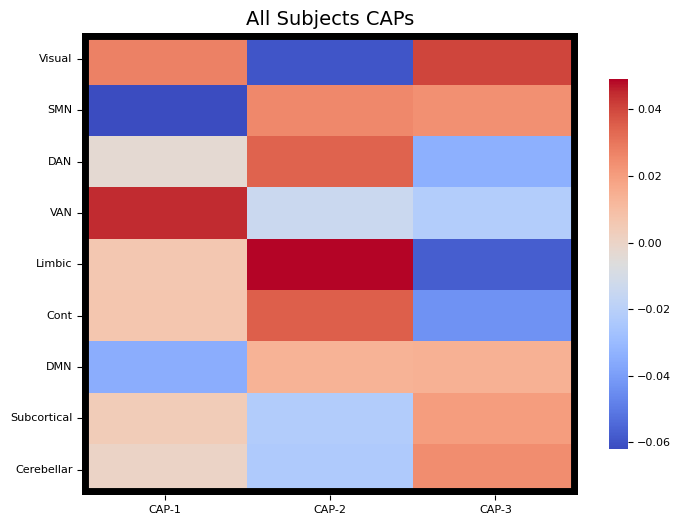

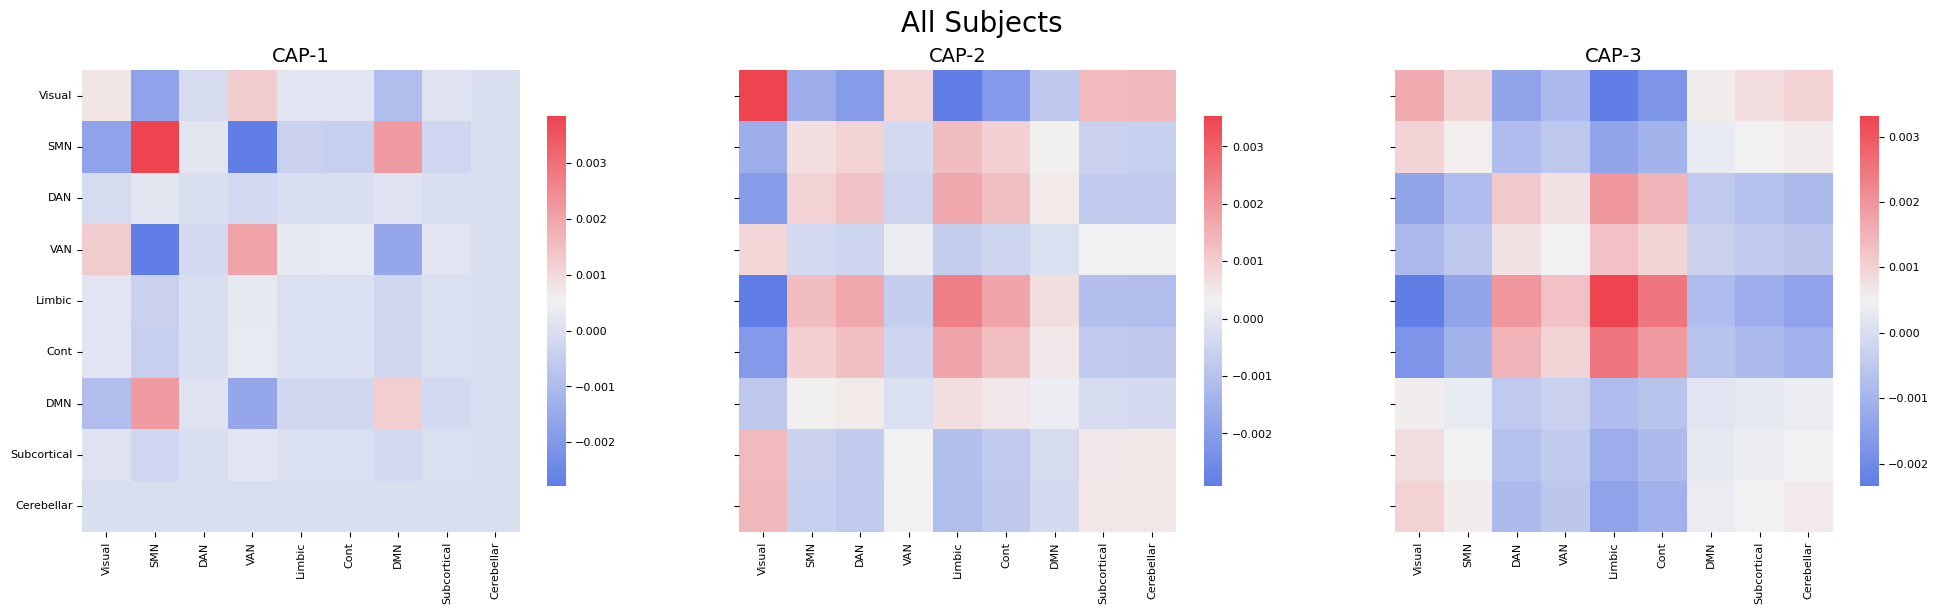

In [5]:
import seaborn as sns

sns.diverging_palette(145, 300, s=60, as_cmap=True)

palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)

cap_analysis.caps2plot(visual_scope="regions", plot_options="heatmap", borderwidths=10)

cap_analysis.caps2plot(
    visual_scope="regions",
    plot_options="outer_product",
    subplots=True,
    fontsize=14,
    tight_layout=False,
    xlabel_rotation=90,
    hspace=0.3,
    cmap=palette,
    output_dir="neurocaps_demo",
)

In [7]:
radialaxis = {
    "showline": True,
    "linewidth": 2,
    "linecolor": "rgba(0, 0, 0, 0.25)",
    "gridcolor": "rgba(0, 0, 0, 0.25)",
    "ticks": "outside",
    "tickfont": {"size": 14, "color": "black"},
    "range": [0, 0.5],
    "tickvals": [0.1, "", 0.3, "", 0.5],
}

color_discrete_map = {
    "High Amplitude": "rgba(255, 165, 0, 0.75)",
    "Low Amplitude": "black",
}

cap_analysis.caps2radar(
    radialaxis=radialaxis,
    fill="toself",
    color_discrete_map=color_discrete_map,
    use_scatterpolar=True,
    output_dir="neurocaps_demo",
)